# Pickle hyper parameters for static conflcit exposure

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import matplotlib as mpl    
mpl.rc('font',family='serif')

import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

import pickle

import time

pm.__version__

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


'3.6'

# Open train pickle:

In [2]:

pkl_file = open('train_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

In [3]:
df.shape

(442008, 10)

In [4]:
max_year = df['year'].max()
max_year

2012

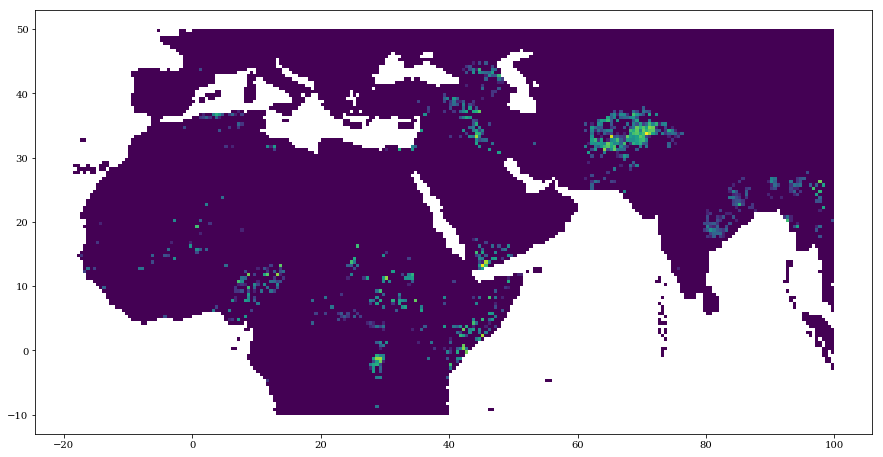

In [5]:
df[df['year']==max_year].plot(column = 'log_best', figsize=(15, 15))
plt.show()

# set hyper priors

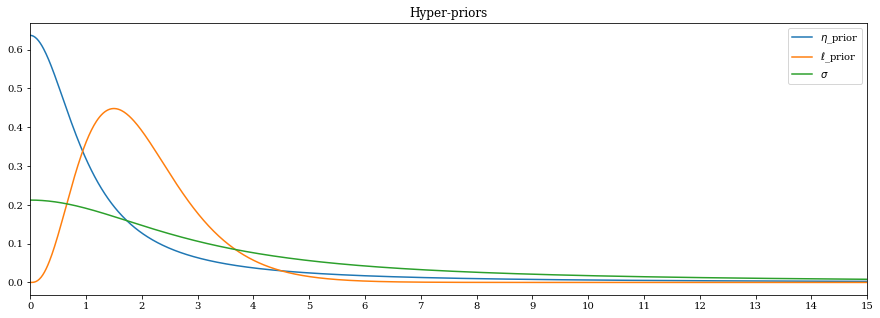

In [6]:
η_beta = 1
ℓ_beta = 2
ℓ_alpha = 4
σ_beta = 3

grid = np.linspace(0,15,1000)
priors = [
    ('$\eta$_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('$\ell$_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('$\sigma$', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('Hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.xticks(np.arange(0,16,1))
plt.xlim(0,15)
plt.legend()
plt.show()

# Estimation hyper parameters:

In [7]:
def est_map(year):
        
    df_y = df[df['year'] == year] 

    X = np.array([df_y['xcoord'], df_y['ycoord']]).T
    y = np.array(df_y['log_best'])

    # for spares estimation:
    df_non_zero = df_y[df_y['best']>0]
    Xu = np.array([df_non_zero['xcoord'], df_non_zero['ycoord']]).T
    
    with pm.Model() as model:
    
        # priors
        ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha, beta=ℓ_beta, shape = 1)
        η = pm.HalfCauchy("η", beta=η_beta, shape = 1)

        # noise model
        σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
        
        cov = η **2 * pm.gp.cov.ExpQuad(2, ℓ)
        
        gp = pm.gp.MarginalSparse(cov_func=cov) # ved ikke om det gør en forskel til FICT
        y_ = gp.marginal_likelihood("y_", X=X, Xu = Xu, y=y, noise= σ)
    
        mp = pm.find_MAP()
        
    return(mp)

In [8]:
def est_map_all_years():
    years =  np.sort(df['year'].unique())
    mp_dict = {}
    
    for i in years:
        
        time_total = 0
        time0 = time.time()
        print('starting{}'.format(i))
        mp = est_map(i)
        mp_dict[str(i)] = mp
        time1 = time.time()
        loop_time = (time1 - time0)/60

        print('done{} in {} min'.format(i,loop_time))
        
        time_total += loop_time

    print('All done{} in {} min'.format(i,time_total))

    return(mp_dict)

In [9]:
mp_dict = est_map_all_years()

starting1989


/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `ar

done1989 in 5.148045031229655 min
starting1990


/home/polichinel/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -13,151, ||grad|| = 495.22: 100%|██████████| 19/19 [06:38<00:00, 20.95s/it]     


done1990 in 7.9673322161038715 min
starting1991


logp = -12,995, ||grad|| = 458.94: 100%|██████████| 20/20 [06:53<00:00, 20.67s/it]     


done1991 in 8.258362591266632 min
starting1992


logp = -13,793, ||grad|| = 795.92: 100%|██████████| 19/19 [10:24<00:00, 32.88s/it]     


done1992 in 11.961049429575603 min
starting1993


logp = -13,258, ||grad|| = 923.59: 100%|██████████| 20/20 [11:11<00:00, 33.60s/it]     


done1993 in 12.816115713119506 min
starting1994


logp = -14,428, ||grad|| = 1,217: 100%|██████████| 18/18 [11:54<00:00, 39.67s/it]     


done1994 in 13.580693562825521 min
starting1995


logp = -13,413, ||grad|| = 847.5: 100%|██████████| 17/17 [09:06<00:00, 32.18s/it]     


done1995 in 10.701766284306844 min
starting1996


logp = -12,629, ||grad|| = 238.23: 100%|██████████| 17/17 [08:47<00:00, 31.02s/it]     


done1996 in 10.273152379194896 min
starting1997


logp = -14,149, ||grad|| = 429.48: 100%|██████████| 18/18 [08:30<00:00, 28.35s/it]     


done1997 in 10.003313692410787 min
starting1998


logp = -15,176, ||grad|| = 370.16: 100%|██████████| 16/16 [11:29<00:00, 43.08s/it]     


done1998 in 13.238196114699045 min
starting1999


logp = -14,969, ||grad|| = 496.41: 100%|██████████| 17/17 [12:04<00:00, 42.61s/it]     


done1999 in 13.971640793482463 min
starting2000


logp = -13,794, ||grad|| = 782.96: 100%|██████████| 18/18 [15:21<00:00, 51.17s/it]      


done2000 in 17.22578393618266 min
starting2001


logp = -13,071, ||grad|| = 722.88: 100%|██████████| 20/20 [12:30<00:00, 37.52s/it]     


done2001 in 14.2061851978302 min
starting2002


logp = -13,155, ||grad|| = 861.75: 100%|██████████| 17/17 [12:39<00:00, 44.67s/it]      


done2002 in 14.350573531786601 min
starting2003


logp = -12,034, ||grad|| = 1,303: 100%|██████████| 21/21 [16:40<00:00, 47.65s/it]      


done2003 in 18.346919842561086 min
starting2004


logp = -12,963, ||grad|| = 993.22: 100%|██████████| 18/18 [13:36<00:00, 45.39s/it]      


done2004 in 15.451238059997559 min
starting2005


logp = -11,067, ||grad|| = 944.72: 100%|██████████| 18/18 [13:34<00:00, 45.26s/it]      


done2005 in 15.417882057030996 min
starting2006


logp = -12,499, ||grad|| = 914.16: 100%|██████████| 18/18 [16:01<00:00, 53.39s/it]      


done2006 in 18.027460300922392 min
starting2007


logp = -11,946, ||grad|| = 740.79: 100%|██████████| 19/19 [17:07<00:00, 54.06s/it]      


done2007 in 19.13151481548945 min
starting2008


logp = -13,057, ||grad|| = 734.65: 100%|██████████| 19/19 [18:35<00:00, 58.71s/it]      


done2008 in 20.763109866778056 min
starting2009


logp = -13,505, ||grad|| = 579.14: 100%|██████████| 17/17 [17:54<00:00, 63.20s/it]       


done2009 in 20.057602894306182 min
starting2010


logp = -11,406, ||grad|| = 729.56: 100%|██████████| 18/18 [16:06<00:00, 53.71s/it]      


done2010 in 18.098664959271748 min
starting2011


logp = -13,763, ||grad|| = 723.08: 100%|██████████| 19/19 [17:30<00:00, 55.30s/it]      


done2011 in 19.795542840162913 min
starting2012


logp = -13,870, ||grad|| = 699.78: 100%|██████████| 18/18 [19:28<00:00, 64.92s/it]       


done2012 in 21.82015519142151 min
All done2012 in 21.82015519142151 min


In [19]:
def get_hyper_par():

    all_ell = []
    all_eta = []
    all_sigma = []
    
    years =  np.sort(df['year'].unique())
    
    for i in years:
        all_ell.append(mp_dict[str(i)]['ℓ'][0])
        all_eta.append(mp_dict[str(i)]['η'][0])
        all_sigma.append(mp_dict[str(i)]['σ'][0])
                       
    return(all_ell, all_eta, all_sigma, years)

In [20]:
all_ell, all_eta, all_sigma, years = get_hyper_par()

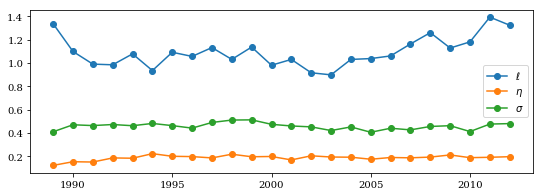

$\ell$ mean: 1.094225252128768
$\eta$ mean: 0.18716566312138003
$\sigma$ mean: 0.45765365899782234


In [28]:
plt.figure(figsize = [9,3])

plt.plot(years, all_ell, 'o-', label = '$\ell$')
plt.plot(years, all_eta, 'o-', label = '$\eta$')
plt.plot(years, all_sigma, 'o-', label = '$\sigma$')

plt.legend()
plt.show()

print('$\ell$ mean: {}'.format(np.mean(all_ell)))
print('$\eta$ mean: {}'.format(np.mean(all_eta)))
print('$\sigma$ mean: {}'.format(np.mean(all_sigma)))

In [28]:
sce_huper_para_dict = {}
sce_huper_para_dict['ℓ'] = all_ell
sce_huper_para_dict['η'] = all_eta
sce_huper_para_dict['σ'] = all_sigma
sce_huper_para_dict['years'] = years


file_name = "spatial_eta.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace.get_values('η'), output)
output.close()

In [29]:
file_name = "spatial_ell.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace.get_values('ℓ'), output)
output.close()

In [30]:
file_name = "spatial_sigma.pkl"
output = open(file_name, 'wb') 
pickle.dump(trace.get_values('σ'), output)
output.close()

# Pickle test:

In [31]:
pkl_file = open('spatial_trace.pkl', 'rb')

pickle_test_trace = pickle.load(pkl_file)

pkl_file.close()

In [32]:
pm.summary(pickle_test_trace, varnames=['η', 'ℓ', 'σ'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
η__0,0.196058,0.003135,0.000073,0.190021,0.202092,1849.025188,1.000839
ℓ__0,1.325628,0.032640,0.000918,1.261821,1.389521,1373.703987,1.000468
σ__0,0.479795,0.002674,0.000066,0.474506,0.484968,1630.980252,1.002241


In [33]:
pkl_file = open('spatial_eta.pkl', 'rb')

pickle_test_eta = pickle.load(pkl_file)

pkl_file.close()

print(np.mean(pickle_test_eta))

0.196058340963208


In [34]:
pkl_file = open('spatial_ell.pkl', 'rb')

pickle_test_ell = pickle.load(pkl_file)

pkl_file.close()

print(np.mean(pickle_test_ell))

1.3256282151267167


In [35]:
pkl_file = open('spatial_sigma.pkl', 'rb')

pickle_test_sigma = pickle.load(pkl_file)

pkl_file.close()

print(np.mean(pickle_test_sigma))

0.47979509065146325
